In [13]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Optimization

This section provides a peek into some of the optimization process that was performed when selecting network architectures and hyperparameters. 

Key highlights include:

1. **Architecture Experiments**  
   - Different layer sizes and numbers of hidden layers were tested to balance accuracy and training stability.  
   - Custom activation functions (e.g., Cosine, Tanh, SiLU, GELU) were evaluated for their ability to capture higher-order derivatives.

2. **Hyperparameter Tuning**  
   - Learning rates, number of epochs, and gradient clipping thresholds were adjusted to improve convergence.  
   - Early stopping criteria were implemented to avoid overfitting and save training time.

3. **Validation Strategy**  
   - Networks were benchmarked against quadrature solutions at key points in the domain (`t=0, t=0.5, t=1`) to ensure physical consistency.  
   - Multiple runs per configuration were performed to measure robustness and reproducibility.

4. **Visualization**  
   - Training loss curves and comparison plots against the quadrature solution were used to evaluate the performance of different architectures.

The accompanying **Optimization notebook** contains the actual experiments and visualizations for these tests.


### Model

This project uses a highly modularized `Net` class that allows for flexible experimentation with:

- **Different architectures**: You can specify any number of layers and neurons per layer.
- **Activation functions**: The network supports custom activations such as CosActivation, Tanh, SiLU, GELU, ReLU, etc.
- **Output scaling**: Minimum and maximum output bounds can be set based on sub- and super-solution estimates to enforce physically admissible solutions.

The default configuration corresponds to the best-performing architecture with:

- **Activation**: `CosActivation` (a custom cosine-based activation designed to better capture higher-order derivatives)
- **Scaling factors**: Set to the bounds for λ = 3.36
- **Layer sizes**: `[1, 32, 32, 32, 1]`

This modular design allows easy testing of different hyperparameters, architectures, and activation functions while maintaining stability and physical consistency.


In [14]:
class CosActivation(nn.Module):
    def forward(self, x):
        return 0.5 * (1 - torch.cos(2 * torch.pi * x))


class Net(nn.Module):
    def __init__(self, layer_sizes=[1, 32, 32, 32, 1], activation=CosActivation, 
                 output_min=0.058579, output_max=0.259033):
        super(Net, self).__init__()
        self.output_min = output_min
        self.output_max = output_max
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(activation())
        
        self.hidden = nn.Sequential(*layers)
        self.output_activation = nn.Sigmoid()

    def forward(self, t):
        raw = self.hidden(t)
        return self.output_min + (self.output_max - self.output_min) * self.output_activation(raw)

### Parameter Sets for Testing

To explore the flexibility and performance of the modular `Net` class, several parameter sets are defined. These sets allow testing of different:

- **$\lambda$ (lambda) values**: Controls the strength of the reaction term in the BVP.
- **$\rho$ (rho) values**: Used for mid-domain solution checks and scaling.
- **Initial conditions (`u0`)**: Starting value for the solution at t = 0.
- **Output bounds**: `output_min` and `output_max` derived from sub- and super-solutions.
- **Network architectures**: Different numbers of layers and neurons.
- **Activation functions**: CosActivation, Tanh, SiLU, GELU, ReLU, etc.

The parameter sets are organized into two groups:

1. **Parameter Sets 1**: Focused on varying $\lambda$, $\rho$, and output bounds while using the default architecture.
2. **Parameter Sets 2**: Designed to explore different layer sizes and activation functions for specific λ values.

These sets provide a comprehensive basis for evaluating the PINN’s performance, stability, and sensitivity to architecture choices.


In [15]:
# Parameters
r = 1
gamma1 = 1

parameter_sets1 = [
    {
        'name': 'lambda_3.36',
        'lambd': 3.36251543,
        'rho': 0.19183673,
        'u0': 0.12950433,
        'output_min': 0.058579,
        'output_max': 0.259033,
    },
    {
        'name': 'lambda_5.85',
        'lambd': 5.84805224,
        'rho': 0.46734694,
        'u0': 0.28840600,
        'output_min': 0.127412,
        'output_max': 0.694759,
    },
    {
        'name': 'lambda_9.53',
        'lambd': 9.53230192,
        'rho': 0.65102041,
        'u0': 0.36987505,
        'output_min': 0.158089,
        'output_max': 1.073834,
    },
    {
        'name': 'lambda_19.38',
        'lambd': 19.37997763,
        'rho': 0.83469388,
        'u0': 0.42421198,
        'output_min': 0.167799,
        'output_max': 1.666294,
    },
    {
        'name': 'lambda_35.26',
        'lambd': 35.26398748,
        'rho': 0.92653061,
        'u0': 0.43838751,
        'output_min': 0.156112,
        'output_max': 2.256968,
    }
]

parameter_sets2 = [
    {
        'name': 'lambda_3.36',
        'lambd': 3.36251543,
        'rho': 0.19183673,
        'u0': 0.12950433,
        'layer_sizes': [1, 16, 32, 64, 1],
        'activation': nn.Tanh,
    },
    {
        'name': 'lambda_3.36',
        'lambd': 3.36251543,
        'rho': 0.19183673,
        'u0': 0.12950433,
        'layer_sizes': [1, 16, 16, 16, 16, 16, 1],
        'activation': nn.SiLU,
    },
    {
        'name': 'lambda_9.53',
        'lambd': 9.53230192,
        'rho': 0.65102041,
        'u0': 0.36987505,
        'output_min': 0.158089,
        'output_max': 1.073834,
        'activation': nn.ReLU,
    },
    {
        'name': 'lambda_35.26',
        'lambd': 35.26398748,
        'rho': 0.92653061,
        'u0': 0.43838751,
        'output_min': 0.156112,
        'output_max': 2.256968,
        'layer_sizes': [1, 32, 32, 1],
    },
    {
        'name': 'lambda_35.26',
        'lambd': 35.26398748,
        'rho': 0.92653061,
        'u0': 0.43838751,
        'output_min': 0.156112,
        'output_max': 2.256968,
        'activation': nn.GELU,
    }
]

### Loss Function, Training, Evaluating

This section covers the core workflow for training the Physics-Informed Neural Network (PINN) and evaluating its performance:

1. **Loss Function**  
   The loss function combines three contributions:
   - **Equation loss (`loss_eq`)**: Measures how well the network satisfies the differential equation at collocation points.
   - **Boundary condition losses (`loss_bc_0` and `loss_bc_1`)**: Enforce the boundary conditions at t = 0 and t = 1.
   
   Gradients are computed with `torch.autograd.grad` to enable automatic differentiation for higher-order derivatives.

2. **Training the Network**  
   - Networks are trained using Adam optimizer with optional learning rate schedulers.
   - Gradient clipping is applied to maintain stability.
   - Early stopping is implemented to terminate training if no improvement occurs for a specified patience interval.
   - Multiple runs can be performed per parameter set to check robustness.

3. **Evaluating the Results**  
   - The trained network is evaluated over a dense grid (`t_test`) to produce predictions.
   - Quadrature solutions are computed using `solve_ivp` for comparison.
   - Average differences at key points (t = 0, 0.5, 1) are computed to assess accuracy.
   - Loss curves and solution plots are generated for visual inspection of convergence and fidelity.

This structured approach ensures that each trained network is physically consistent and can be benchmarked against high-precision numerical solutions.



RUNNING EXPERIMENTS FOR: lambda_3.36
Training completed after 5000 epochs | Final loss: 0.40984398
Training completed after 5000 epochs | Final loss: 0.40984356
Training completed after 5000 epochs | Final loss: 0.40984434
Training completed after 5000 epochs | Final loss: 0.40984276
Training completed after 5000 epochs | Final loss: 0.40984371
Training completed after 5000 epochs | Final loss: 0.40984392
Training completed after 5000 epochs | Final loss: 0.40984330
Training completed after 5000 epochs | Final loss: 0.40984428
Training completed after 5000 epochs | Final loss: 0.40984473
Training completed after 5000 epochs | Final loss: 0.40984374
Run: 10 / 10
Number of passed models: 0
Number of failed models: 10
Average differences for {'name': 'lambda_3.36', 'lambd': 3.36251543, 'rho': 0.19183673, 'u0': 0.12950433, 'layer_sizes': [1, 16, 32, 64, 1], 'activation': <class 'torch.nn.modules.activation.Tanh'>}:
t=0: 0.03829756, t=0.5: 0.02403498, t=1: 0.03829744
Total Time: 9.58 min, 

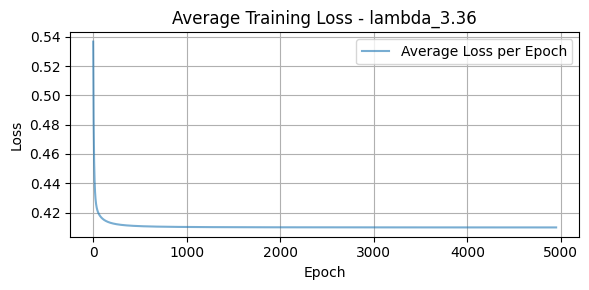

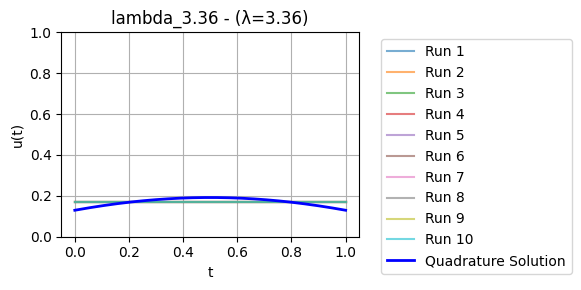


RUNNING EXPERIMENTS FOR: lambda_3.36
Training completed after 5000 epochs | Final loss: 0.40983081
Training completed after 5000 epochs | Final loss: 0.00164159
Training completed after 5000 epochs | Final loss: 0.00347801
Training completed after 5000 epochs | Final loss: 0.40983143
Training completed after 5000 epochs | Final loss: 0.00124889
Training completed after 5000 epochs | Final loss: 0.40983099
Training completed after 5000 epochs | Final loss: 0.40983149
Training completed after 5000 epochs | Final loss: 0.40983123
Training completed after 5000 epochs | Final loss: 0.40983140
Training completed after 5000 epochs | Final loss: 0.00134637
Run: 10 / 10
Number of passed models: 0
Number of failed models: 10
Average differences for {'name': 'lambda_3.36', 'lambd': 3.36251543, 'rho': 0.19183673, 'u0': 0.12950433, 'layer_sizes': [1, 16, 16, 16, 16, 16, 1], 'activation': <class 'torch.nn.modules.activation.SiLU'>}:
t=0: 0.04536791, t=0.5: 0.04512510, t=1: 0.04563171
Total Time: 17

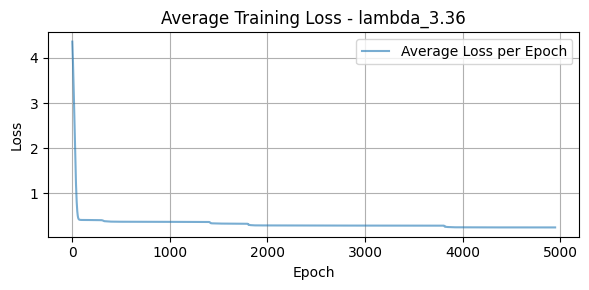

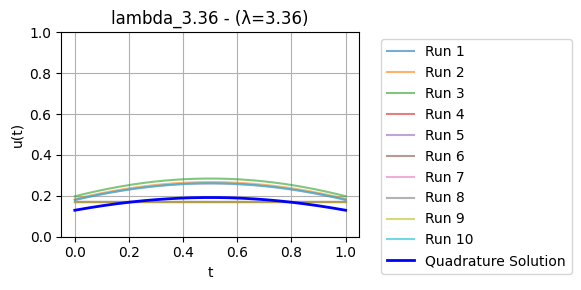


RUNNING EXPERIMENTS FOR: lambda_9.53
Training completed after 5000 epochs | Final loss: 2.08611631
Training completed after 5000 epochs | Final loss: 2.08611536
Training completed after 5000 epochs | Final loss: 2.08611608
Training completed after 5000 epochs | Final loss: 2.08611631
Training completed after 5000 epochs | Final loss: 2.08611608
Training completed after 5000 epochs | Final loss: 2.08611727
Early stopping at epoch 3662 | Best loss: 2.086115
Training completed after 3663 epochs | Final loss: 2.08611465
Training completed after 5000 epochs | Final loss: 2.08611679
Early stopping at epoch 3853 | Best loss: 2.086115
Training completed after 3854 epochs | Final loss: 2.08611488
Training completed after 5000 epochs | Final loss: 2.08611631
Run: 10 / 10
Number of passed models: 0
Number of failed models: 10
Average differences for {'name': 'lambda_9.53', 'lambd': 9.53230192, 'rho': 0.65102041, 'u0': 0.36987505, 'output_min': 0.158089, 'output_max': 1.073834, 'activation': <cla

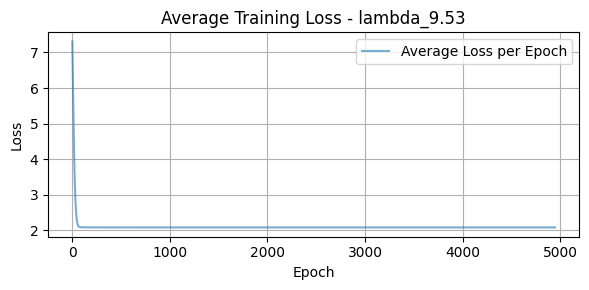

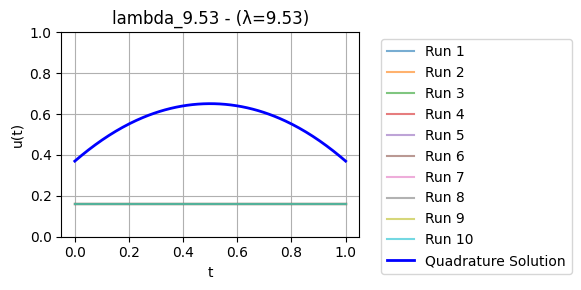


RUNNING EXPERIMENTS FOR: lambda_35.26
Early stopping at epoch 1690 | Best loss: 0.124752
Training completed after 1691 epochs | Final loss: 0.15339845
Early stopping at epoch 2124 | Best loss: 0.148456
Training completed after 2125 epochs | Final loss: 0.23266818
Early stopping at epoch 2219 | Best loss: 0.125739
Training completed after 2220 epochs | Final loss: 0.20918848
Early stopping at epoch 3197 | Best loss: 0.051321
Training completed after 3198 epochs | Final loss: 0.13535565
Early stopping at epoch 2214 | Best loss: 0.162378
Training completed after 2215 epochs | Final loss: 0.23530541
Early stopping at epoch 3084 | Best loss: 0.044774
Training completed after 3085 epochs | Final loss: 0.09357170
Early stopping at epoch 2388 | Best loss: 0.123305
Training completed after 2389 epochs | Final loss: 0.16405019
Early stopping at epoch 2688 | Best loss: 0.094258
Training completed after 2689 epochs | Final loss: 0.11613711
Early stopping at epoch 1636 | Best loss: 0.149547
Traini

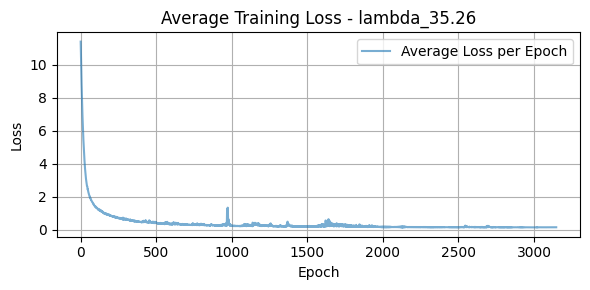

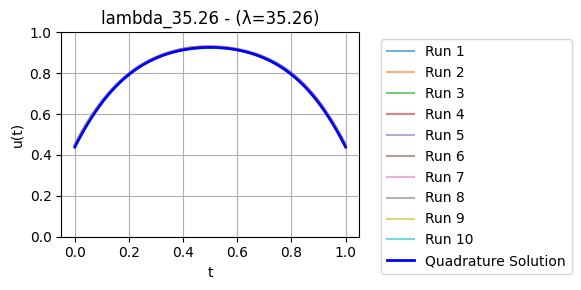


RUNNING EXPERIMENTS FOR: lambda_35.26
Early stopping at epoch 2463 | Best loss: 0.002747
Training completed after 2464 epochs | Final loss: 0.02748120
Early stopping at epoch 2933 | Best loss: 0.001522
Training completed after 2934 epochs | Final loss: 0.00242855
Early stopping at epoch 2866 | Best loss: 0.001735
Training completed after 2867 epochs | Final loss: 0.00328415
Early stopping at epoch 2381 | Best loss: 0.002501
Training completed after 2382 epochs | Final loss: 0.00391674
Early stopping at epoch 2468 | Best loss: 0.002898
Training completed after 2469 epochs | Final loss: 0.00319263
Early stopping at epoch 2500 | Best loss: 0.001831
Training completed after 2501 epochs | Final loss: 0.00355929
Early stopping at epoch 3454 | Best loss: 0.000852
Training completed after 3455 epochs | Final loss: 0.00244597
Early stopping at epoch 4954 | Best loss: 0.000991
Training completed after 4955 epochs | Final loss: 0.00454505
Early stopping at epoch 3180 | Best loss: 0.001968
Traini

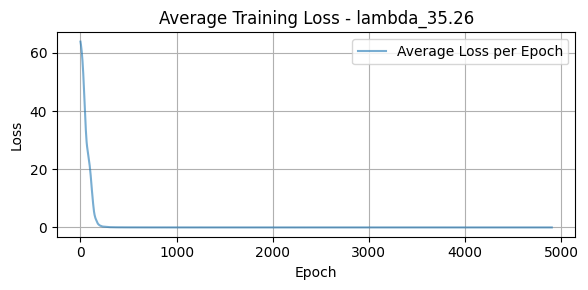

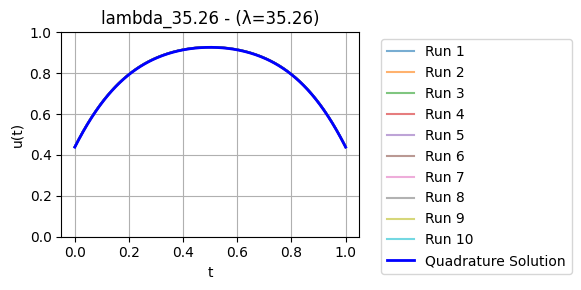


ALL EXPERIMENTS COMPLETED


In [16]:
def loss_function(u_pred, t, net, params):
    u_t = u_pred
    u_t_grad = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]
    u_t_grad2 = torch.autograd.grad(u_t_grad, t, torch.ones_like(u_t_grad), create_graph=True, allow_unused=True)[0]
    
    lambd = params['lambd']
    
    f = -u_t_grad2 - lambd * r * u_t * (1 - u_t)
    loss_eq = torch.mean(f**2)
    
    t_0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True, device=device)
    t_1 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True, device=device)
    u_0 = net(t_0)
    u_1 = net(t_1)
    
    u_0_grad = torch.autograd.grad(u_0, t_0, torch.ones_like(u_0), create_graph=True)[0]
    u_1_grad = torch.autograd.grad(u_1, t_1, torch.ones_like(u_1), create_graph=True)[0]
    
    loss_bc_0 = ((-u_0_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_0) ** 2).mean()
    loss_bc_1 = ((u_1_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_1) ** 2).mean()
    
    return loss_eq, loss_bc_1, loss_bc_0


def train_model(net, optimizer, run_num, params, param_name, scheduler=None, n_epochs=3000, patience=500):
    t_values = torch.linspace(0, 1, 500, device=device).view(-1, 1)
    t_values.requires_grad_()
    losses = []
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        u_pred = net(t_values)
        loss_eq, loss_bc_0, loss_bc_1 = loss_function(u_pred, t_values, net, params)

        total_loss = loss_eq + loss_bc_0 + loss_bc_1

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        loss_val = total_loss.item()

        if epoch >= 50:
            losses.append(total_loss.item())
        
        if loss_val < best_loss:
            best_loss = loss_val
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} | Best loss: {best_loss:.6f}")
            break

    best_loss = loss_val
    print(f"Training completed after {epoch+1} epochs | Final loss: {best_loss:.8f}")
    return net(t_values).detach().cpu().numpy().flatten(), losses


def F(u):
    return 0.5 * u**2 - (1/3) * u**3


def ode1(t, u, rho, lambd):
    val = 2 * lambd * r *(F(rho) - F(u))
    return np.sqrt(np.maximum(val, 0))



parameter_sets = parameter_sets2 # Choose an example parameter sets (parameter_sets1 or parameter_sets2)

N_RUNS = 10
t_test = np.linspace(0, 1, 500)

# Main loop: iterate through each parameter set
for params in parameter_sets:
    print("\n" + "="*80)
    print(f"RUNNING EXPERIMENTS FOR: {params['name']}")
    print("="*80)
    
    # Extract parameters
    lambd = params['lambd']
    rho = params['rho']
    u0 = params['u0']
    output_min = params.get('output_min', 0.167799)
    output_max = params.get('output_max', 1.666294)
    layer_sizes = params.get('layer_sizes', [1, 32, 32, 32, 1])
    activation = params.get('activation', CosActivation)

    # Compute quadrature solution for this parameter set
    sol1 = solve_ivp(ode1, [0, 0.5], [u0], args=(rho, lambd), 
                     dense_output=True, rtol=1e-9, atol=1e-12)
    t1 = np.linspace(0, 0.5, 100)
    u1 = sol1.sol(t1)
    t2 = 1 - t1
    u2 = u1[:, ::-1]
    
    t_quad = np.concatenate([t1, t2[::-1]])
    u_quad = np.concatenate([u1.flatten(), u2.flatten()])
    
    # Loop through layer configurations
    start_time = time.time()
    all_outputs = []
    all_losses = []
    passed_runs = 0
    failed_runs = 0

    for i in range(N_RUNS):
        net = Net(output_min=output_min, 
                    output_max=output_max, activation=activation, layer_sizes=layer_sizes).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        try:
            output, losses = train_model(net, optimizer, i+1, params, params['name'], scheduler=None, n_epochs=5000)
            all_outputs.append(output)
            all_losses.append(losses)
        except Exception as e:
            print(f"Run {i+1} failed: {e}")
            failed_runs += 1
            continue

        t_tensor = torch.tensor(t_test, dtype=torch.float32, device=device).unsqueeze(1)
        u_pred_test = net(t_tensor).detach().cpu().numpy().flatten()
        idx_05 = np.argmin(np.abs(t_test - 0.5))

        if abs(rho - u_pred_test[idx_05]) < 1e-2:
            passed_runs += 1
            
        else:
            failed_runs += 1

        print(f"Run: {i + 1} / {N_RUNS}", end='\r')
    

    print(f"\nNumber of passed models: {passed_runs}")
    print(f"Number of failed models: {failed_runs}")

    all_outputs = np.array(all_outputs)
    idx_05 = np.argmin(np.abs(t_test - 0.5))

    diffs_0 = [abs(u0 - output[0]) for output in all_outputs]
    diffs_05 = [abs(rho - output[idx_05]) for output in all_outputs]
    diffs_1 = [abs(u0 - output[-1]) for output in all_outputs]

    avg_diff_0 = np.mean(diffs_0)
    avg_diff_05 = np.mean(diffs_05)
    avg_diff_1 = np.mean(diffs_1)

    print(f"Average differences for {params}:")
    print(f"t=0: {avg_diff_0:.8f}, t=0.5: {avg_diff_05:.8f}, t=1: {avg_diff_1:.8f}")
    
    end_time = time.time()
    elapsed = end_time - start_time
    ave_elap = elapsed / N_RUNS
    elap_min = elapsed / 60
    print(f"Total Time: {elap_min:.2f} min, Avg per run: {ave_elap:.2f} sec")
    print("-" * 60)

    # Plot results - handle variable length losses due to early stopping
    if len(all_losses) > 0:
        max_len = max(len(loss_list) for loss_list in all_losses)
        
        # Pad all loss lists to same length with their final value
        padded_losses = []
        for loss_list in all_losses:
            if len(loss_list) < max_len:
                # Pad with the last loss value
                padded = loss_list + [loss_list[-1]] * (max_len - len(loss_list))
            else:
                padded = loss_list
            padded_losses.append(padded)
        
        all_losses = np.array(padded_losses)
        avg_losses = np.mean(all_losses, axis=0)
    else:
        print("No successful runs to plot")

    plt.figure(figsize=(6, 3))
    plt.plot(avg_losses, label='Average Loss per Epoch', alpha=0.6)
    plt.title(f"Average Training Loss - {params['name']}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(6, 3))
    for j, output in enumerate(all_outputs):
        plt.plot(t_test, output, alpha=0.6, label=f'Run {j+1}')
    plt.plot(t_quad, u_quad, label="Quadrature Solution", color="blue", linewidth=2)
    plt.title(f"{params['name']} - (λ={lambd:.2f})")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED")
print("="*80)